# Perceptual loss - Style transfer in a single forward pass

Paper:https://arxiv.org/abs/1603.08155


Idea: Train a transformation network which transforms an input image X into an image X' in the style of a style image S using a single forward pass, without having to solve an optimization problem for each style transfer.

To compute the loss, use a pretrained model which assesses the perceptual quality of the generated image. This essentially evaluates the model in the feature space.



In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Input
from IPython.display import Image, display


# Image preprocessing

Images in:
- Input image X -> image we want to transform
- Content image C -> Image from which we want the content. Isn't that X for style transfer??
- Style image S -> Image which contains the style we want to extract.


## Preprocessing steps

content image (PIL)

        |
        |
        V
Some tensor ?
        |
        |
        V
Transform network
        |
        |
        V
Some tensor
        |
        |
        V       
Loss network (VGG16)
    |   |   |   |
    V   V   V   V
    Loss components from different layers
    

In [7]:
# content image (PIL)
#        |
#        |
#        V
# Some tensor 
#        |
#        |
#        V
# Transform network
#        |
#        |
#        V
# Some tensor
#        | |
#        | |
#        V V      
# Loss network (VGG16)
#    |   |   |   |
#    V   V   V   V
#    Loss components from different layers

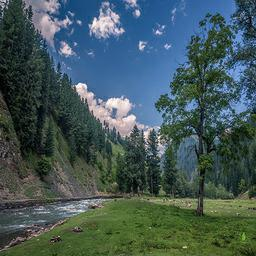

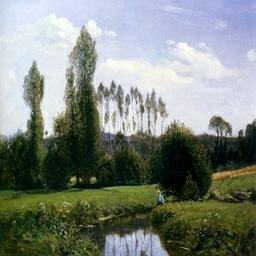

In [2]:
# Load images
content_image = "0cae98323f"
style_image = "8b841420b4"

base_path_content = "../../data/art/photo_jpg/"
base_path_style = "../../data/art/monet_jpg/"


content_image_path = base_path_content + content_image + ".jpg"
style_image_path = base_path_style + style_image + ".jpg"

display(Image(content_image_path))
display(Image(style_image_path))

In [3]:
# Get dimension of image and set the dimension of the generated image.
width, height = keras.preprocessing.image.load_img(content_image_path).size

print(width, height)

256 256


In [4]:
# Preprocess and postprocess images
def preprocess_image_transform_net(full_image_path):
    """
    Transforms the input content image into the format required by
    the transformation network.

    Returns:
    Tensorflow tensor
    """
    # TODO: Implement after network is defined!
    return None


def postprocess_image_transform_net(image_as_tensor):
    """
    Transforms an image from the tensorflow tensor format into a PIL image.
    """
    # TODO: Finish implementation according to the requirements of the 
    # transform network.
    image = image_as_tensor.reshape((width, height, 3))
    # TODO: Remove some scaling or whatever maybe. Also maybe from BGR -> RGB.


    return image




def preprocess_image_loss_net(full_image_path):
    """
    Transforms the image at the path into a tensorflow tensor according to the 
    vgg16 requirements.

    Takes the style and conent images.
    """


    img = keras.preprocessing.image.load_img(full_image_path)
    img = keras.preprocessing.image.img_to_array(img)
    # Adds batch dimension. Shape is (batch, height, width, colour)
    img = np.expand_dims(img, axis=0)
    # Convert RGB to BGR and zero centre each colour channel according to ImageNet.
    # Does not perform scaling.
    img = vgg16.preprocess_input(img)
    # Convert to tensorflow tensor
    img = tf.convert_to_tensor(img)
    return img


def preprocess_tensor_for_loss_net(x):
    """
    Takes the tensor which is returned by the transformation network and preprocesses
    it for the loss network.

    TODO: Implement
    """

    return None





In [5]:
img = keras.preprocessing.image.load_img(content_image_path)
img = keras.preprocessing.image.img_to_array(img)

# Adds batch dimension. Shape is (batch, height, width, colour)
img = np.expand_dims(img, axis=0)
# Convert RGB to BGR and zero centre each colour channel according to ImageNet.
# Does not perform scaling.
# Convert to tensorflow tensor
img = tf.convert_to_tensor(img)

Metal device set to: 

2021-11-18 17:47:11.030174: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-18 17:47:11.030696: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



# Define transform and loss networks

In [ ]:
# Transform network

In [11]:
# Loss network
# Input: 224x224 -> Do I have to resize the input image from 256x256 or does the model not care?
loss_net = vgg16.VGG16(include_top=False, weights="imagenet", input_tensor=Input(shape=(256,256,3)))
loss_net_outputs = dict([(layer.name, layer.output) for layer in loss_net.layers])

loss_net_activations = keras.Model(inputs=loss_net.inputs, outputs=loss_net_outputs)

In [12]:
loss_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

# Define loss function

In [13]:
# Style: 1,2,3,4
style_layers = [
    "block1_conv2",
    "block2_conv2",
    "block3_conv3",
    "block4_conv3"
]

# Content: 3
content_layer = "block3_conv3"

In [ ]:
# Hashtables: layer -> [height, width, channels]

style_layers = {
    "block1_conv2": [],
    "block2_conv2": [],
    "block3_conv3": [],
    "block4_conv3" : []
}
content_layer = {"block3_conv3": [64,64,256]}

In [14]:
# Feature loss (content loss)

# Define input image shape
channels = 3
height = 256
width = 256

def compute_content_loss(generated, content, dimensions):
    """
    Computes the content loss from the given features.
    Equation 2 in paper.

    Args:
    generated:  Tensor feature map of the generated image.
    content:    Tensor feature map of the content image.
    dimensions: List of layer dimensions [height, width, channels]
    """

    # Two tensorflow tensors
    # TODO: Fix this factor!
    # Factors are for layer 3.3.
    height, width, channels = dimensions[0], dimensions[1], dimensions[2]

    factor = 1 / (int(height/4) * int(width/4) * 256)
    content_reconstruction_loss =  factor * tf.math.reduce_sum(tf.square(generated - content)) # Squared euclidian norm
    return content_reconstruction_loss


def gram_matrix(x):
    x = tf.transpose(x, (2,0,1))
    features = tf.reshape(x, (tf.shape(x[0], -1)))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def compute_style_loss(generated, style, dimensions):
    """
    Compute style loss for one layer.

    """
    # Dimensions
    height, width, channels = dimensions[0], dimensions[1], dimensions[2] 
    size = height * width

    generated = gram_matrix(generated)
    style = gram_matrix(style)
    res = tf.reduce_sum(tf.square(generated, style)) / (4 * (channels**2) * (size**2))
    return res








In [16]:
def compute_loss(generated_image, content_image, style_image):
    # Combine input tensor to make one pass with all in paralell.
    input_tensors = tf.concat([generated_image, content_image, style_image], axis=0)

    # Forward pass
    features = loss_net(input_tensors)

    # Initialize loss
    loss = tf.zeros(shape=())

    # Compute content loss
    layer_features = features[content_layer.keys()[0]]
    generated_features = layer_features[0,:,:,:]
    content_features = layer_features[1,:,:,:]
    loss += compute_content_loss(generated_features, content_features, content_layer.values[0])

    # Compute style loss
    for style_layer in style_layers.keys():
        layer_features = features[style_layer]
        generated_features = layer_features[0,:,:,:]
        style_features = layer_features[2,:,:,:]
        loss += compute_style_loss(generated_features, style_features, style_layers[style_layer]) # TODO: Do we have to scale this?

    return loss
